Initialize the calibration image and parse the points from lidar data

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import math as m
import numpy as np

def read_file(filename):
  point_array = []
  file = open(filename, 'r')
  lines = file.readlines()
  for line in lines:
    data = line[line.find(':')+1: line.find(']')-1]
    for entry in data.split(';'):
      values = entry.split('|')
      d = float(values[0])
      h = float(values[1])
      v = float(values[2])
      diag = d * m.cos(v);
      point_array += [[diag * m.cos(h), diag * m.sin(h), d * -m.sin(v)]]
  return np.float64(point_array)

def eulerAnglesToRotationMatrix(theta):
  R_x = np.matrix([[ 1, 0 , 0],
                   [ 0, m.cos(theta[0]),-m.sin(theta[0])],
                   [ 0, m.sin(theta[0]), m.cos(theta[0])]])
  R_y = np.matrix([[ m.cos(theta[1]), 0, m.sin(theta[1])],
                   [ 0, 1, 0 ],
                   [-m.sin(theta[1]), 0, m.cos(theta[1])]])
  R_z = np.matrix([[ m.cos(theta[2]), -m.sin(theta[2]), 0 ],
                   [ m.sin(theta[2]), m.cos(theta[2]) , 0 ],
                   [ 0, 0, 1 ]])
  return R_z * R_y * R_x

# Load calibration image in Grayscale
img = cv2.imread('./probe.png')

#Load and parse lidar point from the text file
point_array = np.array(read_file("probe_points.txt"))

Code to visualize the lidar datapoints. Lidar points are shown relative to lidar. So lidar is at point (0,0,0), take note where that point is, as points in the 3d projection are essentially shown from "behind".

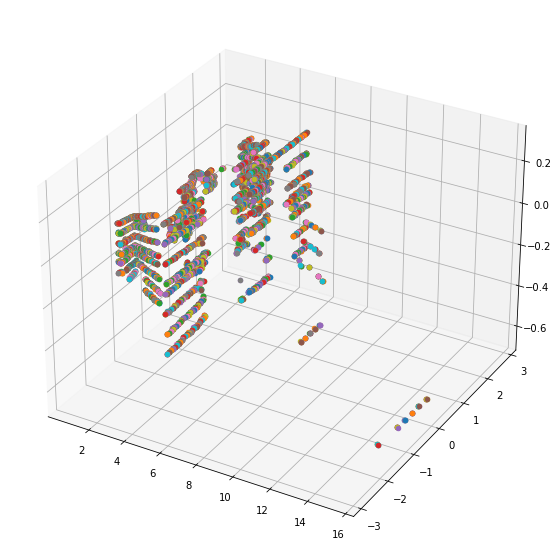

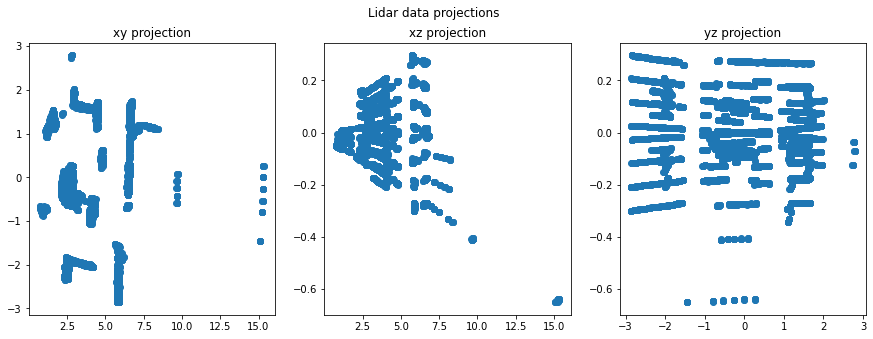

NameError: name 'fig1' is not defined

<Figure size 432x288 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
for point in point_array:
  ax.scatter(point[0],point[1],point[2])
plt.show()

x = point_array[:,0]
y = point_array[:,1]
z = point_array[:,2]

fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig2.suptitle("Lidar data projections")
ax1.set_title('xy projection')
ax2.set_title('xz projection')
ax3.set_title('yz projection')
ax1.scatter(x,y)
ax2.scatter(x,z)
ax3.scatter(y,z)
plt.show()






The following code projects the lidar points on top of the calibration image according to the specifications from variables. Remember to switch the is_colab variable to false if you are using the anaconda + opencv (you can install opencv for anaconda python by running "conda install -c conda-forge opencv" from command line)

In [83]:
is_colab = False
import time

if is_colab:
  from google.colab import output
  import matplotlib.pyplot as plt
else:
  cv2.namedWindow("calib")
# Initialize calibration parameters

# Initialize camera axes
camera_axis = np.float64([[0, -1, 0],
                          [0, 0, -1],
                          [1, 0, 0]])

# Initialize matrix for the camera parameters
w = 1280
h = 720
fx = 1
K = np.float64([[fx*w, 0, 0.5*(w-1)],
                [0, fx*w, 0.5*(h-1)],
                [0.0, 0.0, 1.0]])

# Initialize intrinsic distortion coefficients
#dist_coef = np.float64([0, 0, 0, 0, 0])
dist_coef = np.float64([-0.4, 0.6, 0, 0, 0.1])

# Initialize extrinsic distortion parameters
# Initialize camera rotation angles
#rotation = np.float64([0, 0, 0])
rotation = np.float64([0, -0.019, 0.024])
#-0.02, -0.025, 0.02
#-0.03, -0.16, 0.07
#-0.4, 0.6, 0, 0, 0

rvec = cv2.Rodrigues(camera_axis*eulerAnglesToRotationMatrix(rotation))[0]

# Initialize camera displacement parameters
#tvec = np.float64([0, 0, 0])
tvec = np.float64([-0.025, -0.2, 0])

def createProjection(img, point_array, rvec, tvec, K, dist_coef):
  proj_img = img.copy()
  projected = cv2.projectPoints(point_array, rvec, tvec, K, dist_coef)[0]
  for idx, point in enumerate(projected):
    val = point[0]
    if (val[0] < 0) or (val[0] > w) or (val[1] < 0) or (val[1] > h):
      continue
    color = point_array[idx][0]*255/7;
    if(color > 255):
      color = 255
    cv2.circle(proj_img, (int(val[0]), int(val[1])), 2,(255-color, 0, color), 2)
  cv2.putText(proj_img, "rotation: "+str(rotation)+" tvec: "+str(tvec)+" dist_coeffs: "+str(dist_coef), (0,50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0),2)
  return proj_img


running = True
cmd = ""
while running:
  if cmd != "repeat":
    proj_img = createProjection(img, point_array, rvec, tvec, K, dist_coef)
  cmd = ""
  if is_colab:
    output.clear()
    #TODO: In case you want smaller or bigger image, change the figsize parameter
    fig, ax = plt.subplots(figsize=(15,10))
    ax.imshow(proj_img, interpolation='nearest', aspect='auto')
    plt.show() 
     
    #TODO: If you are using google colab and don't want to go over every possible value by hand (restarting the program each time),
    #      You can use the while loop to change one value (for example tvec[1] += 0.01) every iteration and redraw the image after 1 second
    #      This way you can check multiple values at a time and you will see the current value on top of the image
    time.sleep(1)
    cmd = "repeat"
  else:
    cv2.imshow( "calib", proj_img );
    #TODO: For users of opencv with anaconda, you can use cv2.waitKey(10) to read the input data from keyboard.
    #      By mapping 'a' and 'd' keys to increasing and decreasing tvec[0] by 0.01, you can quickly see how changing the parameters changes the mapping of the points
    key = cv2.waitKey(100)
    if key == 27:
        running = False
    elif key == 97:
        rotation[0] += 0.002
    elif key == 122:
        rotation[0] -= 0.002
    elif key == 101:
        rotation[1] += 0.002
    elif key == 114:
        rotation[1] -= 0.002
    elif key == 116:
        rotation[2] += 0.002
    elif key == 121:
        rotation[2] -= 0.002


    elif key == 113:
        tvec[0] += 0.005
    elif key == 115:
        tvec[0] -= 0.005
    elif key == 100:
        tvec[1] += 0.005
    elif key == 102:
        tvec[1] -= 0.005
    elif key == 103:
        tvec[2] += 0.005
    elif key == 104:
        tvec[2] -= 0.005
        
    elif key == 119:          #d1 (W, X)
        dist_coef[0] -= 0.01
    elif key == 120:
        dist_coef[0] += 0.01
    elif key == 99:           #d2 (C, V)
        dist_coef[1] -= 0.01
    elif key == 118:
        dist_coef[1] += 0.01
    elif key == 58:           #d5 (:,!)
        dist_coef[4] += 0.01
    elif key == 33:
        dist_coef[4] -= 0.01
    else:
        cmd = "repeat"
    if key != -1:
        print("key:",key)

  #time.sleep(1)

  #Update the rvec based on the changes to rotation made in the loop
  rvec = cv2.Rodrigues(camera_axis*eulerAnglesToRotationMatrix(rotation))[0]
  
  # Since nothing is changed to the parameters in the loop, we exit it immediately
  #running = False

if not is_colab:
    cv2.destroyWindow("calib")

key: 27
